<a href="https://colab.research.google.com/github/tpmmthomas/fyp-chord-identification/blob/tokaho/jupyter_notebook_playground/General_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install music21

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

Hello Google Drive!

In [ ]:
from music21 import *
import music21
import os
import glob
import re
import numpy as np
import math

In [ ]:
def cal_offset(e):
    if e is None:
        return 0
    return e.offset+cal_offset(e.activeSite)

In [ ]:
class Score_in_beat:
    
    def __init__(self):
        self.beat_list=[Beat()]
        
    #extract info from note and add to corrsponding beat
    def add_note(self,note):
        length=note.quarterLength
        start=cal_offset(note)
        end=start+length
        rounded_floor_start=math.floor(start)
        #loop until the note played to its end
        while start<end-0.000000000001:
            if len(self.beat_list)-1<rounded_floor_start:
                new_beat=rounded_floor_start-(len(self.beat_list)-1)
                #the input note maybe is a chord -> recurse all pitch inside
                for _ in range(new_beat):
                    self.beat_list.append(Beat())
            self.beat_list[rounded_floor_start].add_note(note,min(rounded_floor_start+1-start,end-start))
            start+=min(rounded_floor_start+1-start,end-start)
            rounded_floor_start=int(start)
            
    #add key to the first occurence of beat
    def add_key(self,note):
        key_change_beat=cal_offset(note)
        rounded_floor_key_change_beat=math.floor(key_change_beat)
        self.beat_list[rounded_floor_key_change_beat].add_key(note.lyric.split('(')[0])
        
    #onyl call once
    def infer_key(self):
        for e in self.beat_list:
            if e.key_full is not None:
                e.key_full=1
                e.key_in_num=1
                e.major=1
            else:
                e.key_full=0
                e.key_in_num=0
                e.major=0

In [ ]:
key_mapping={
    'C':0,
    'D':2,
    'E':4,
    'F':5,
    'G':7,
    'A':9,
    'B':11
}
def key2num(k):  
    k=k.upper()
    num=key_mapping[k[0]]
    modifier=len(k)
    if modifier==1:
        return num
    elif k[1]=='#':
        return (num+(modifier-1))%12
    elif k[1]=='B' or k[1]=='-' or k[1]=='♭':
        return (num-(modifier-1))%12
    elif k[1]=='X':
        return (num+(modifier-1)*2)%12

In [ ]:
class Beat:
    def __init__(self):
        self.notes = np.zeros((12,7))  #from C1 to C7
        self.total_duration = np.zeros((12,7))
        self.notes_occurences_count= np.zeros((12,7))
        self.key_full=None
        self.major=None
        self.key_in_num=None
        
    def add_note(self,note,duration):
        assert(duration<=1)
        pitches=note.pitches
        for pitch in pitches:
            pitch_idx=key2num(pitch.nameWithOctave[:-1])
            octave=int(pitch.nameWithOctave[-1])-1
            if octave<0:
                octave=0
            elif octave>6:
                octave=6
            self.notes[pitch_idx,octave]=1
            self.total_duration[pitch_idx,octave]+=duration
            self.notes_occurences_count[pitch_idx,octave]+=1
            
    def add_key(self,k):
        self.key_full=k
        self.key_in_num=1

In [ ]:
#piece='./Chopin_F._Nocturne_in_E_Major,_Op.26_No.2.mxl'
all_score=[]
for piece in glob.glob("/gdrive/MyDrive/fyp/musicxml(notated)/*.mxl"):
    all_beat=Score_in_beat()
    all_score.append(all_beat)
    print(piece)
    chords = []
    notes = []
    c = converter.parse(piece)
    post = c.flat

    #extract note
    all_notes=[]
    for note in post.notes:
        all_notes.append(note)
        all_beat.add_note(note)
        if note.lyric is not None:
            all_beat.add_key(note)
        #print(note,note.pitches,note.pitches[0].nameWithOctave,note.quarterLength,cal_offset(note))

    all_beat.infer_key()

/gdrive/MyDrive/fyp/musicxml(notated)/Prlude_Opus_28_No._4_in_E_Minor.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Waltz_in_Eb_Major.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/E╠ütude_in_F_Minor.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Sonatina_in_G.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/E╠ütude_in_F_Major.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Nocturne_in_F#_Major.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Twinkle-Twinkle.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/E╠ütude_in_C_Minor.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Sonate_No._28_2nd_mov.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Sonate_No._28.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Nocturne_in_B_Major.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Waltz_in_A_Minor.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Il_Vecchio_Castello.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Nocturne_in_Eb_Major.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Pre╠ülude_in_B_Major.mxl
/gdrive/MyDrive/fyp/musicxml(notated)/Pre╠ülude_in_B_Minor.mxl
/gdrive/M

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X=[]
Y=[]
weight=[1.35,1.25,1.1,1,0.9,0.8,0.7]
for e in all_score:
    tempX=[]
    tempY=[]
    count=0
    for beat in e.beat_list:
        value=beat.total_duration*beat.notes_occurences_count
        if np.sum(value)!=0:
            #value/=np.sum(value)
            #value*=weight
            #value=value.sum(axis=1)
            value=value.reshape((-1))
            value/=value.sum()
        else:
            value=np.zeros((84))
            
        assert(len(value)==84)
        tempX.append(value)
        
        prepare_y=beat.key_full
        tempY.append(prepare_y)
        count+=1
    X.append(tempX)
    Y.append(tempY)

In [ ]:
look_forward=10
look_after=10
dataX,dataY=[],[]
for idx_p,piece in enumerate(X):
    for idx_b,beat in enumerate(piece):
        tempX=[]
        for i in reversed(range(1,look_forward+1)):
            if(idx_b-i)<0:
                tempX.append(np.zeros(84))
            else:
                tempX.append(piece[idx_b-i])
        tempX.append(piece[idx_b])
        for i in range(1,look_after+1):
            if(idx_b+i)>len(piece)-1:
                tempX.append(np.zeros(84))
            else:
                tempX.append(piece[idx_b+i])
        dataX.append(tempX)
        dataY.append(Y[idx_p][idx_b])

In [ ]:
dataX=np.array(dataX)
dataY=np.array(dataY)

In [ ]:
dataY=dataY.reshape((-1,1))

In [ ]:
dataX.shape,dataY.shape

((8690, 21, 84), (8690, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=2104)

In [ ]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [ ]:
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
import tensorflow as tf

In [ ]:
a,b=numpy.unique(dataY, return_counts=True)

In [ ]:
sample_weight=np.array([b[1],b[0]])
sample_weight=sample_weight/sample_weight.sum()
classweight={0:sample_weight[0],
             1:sample_weight[1]}

In [ ]:
def get_model():
  in_data = Input(shape=(1+look_forward+look_after,84))

  lstm = Bidirectional(LSTM(256,return_sequences=True))(in_data)
  lstm = Flatten()(lstm)


  lstm_2 = Dense(12,activation='relu')(lstm)
 # lstm_2 = Dense(4,activation='relu')(lstm_2)
  output2=Dense(1,activation='sigmoid',name='majorPrediction')(lstm_2)

  model = Model(inputs=in_data, outputs=output2)

  losses ={
        #  'keyPrediction':'categorical_crossentropy',
          'majorPrediction':tf.keras.losses.Huber()    #'binary_crossentropy'#
        }

  lossWeights={
        #  'keyPrediction':0.7,
          'majorPrediction':1  
        }
      
  model.compile(  loss=losses,
                loss_weights= lossWeights,
                optimizer='adam',

                metrics=['accuracy'])
  return model

In [ ]:
callback=EarlyStopping(
    monitor='val_loss', min_delta=0, patience=30, verbose=2, mode='auto',
    baseline=None, restore_best_weights=True)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
sample_weight

array([0.35339471, 0.64660529])

In [ ]:
num_folds=5
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
acc_per_fold = []
loss_per_fold = []
acc2_per_fold=[]
acc3_per_fold=[]
k_fold_x=dataX
k_fold_y=dataY
for train, test in kfold.split(k_fold_x, k_fold_y):

  model=get_model()


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(k_fold_x[train], k_fold_y[train],
                      validation_data=(k_fold_x[test], k_fold_y[test]),
                      verbose=0, 
                      epochs=1000,
                      callbacks=[callback],  
                      batch_size=512,
                      class_weight=classweight,
                      shuffle=True)

  # Generate generalization metrics
  scores = model.evaluate(k_fold_x[test], k_fold_y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

  


  acc_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Score for fold 1: loss of 0.08702141791582108; accuracy of 73.30264449119568%
------------------------------------------------------------------------
Training for fold 2 ...
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
Score for fold 2: loss of 0.08015640079975128; accuracy of 77.96317338943481%
------------------------------------------------------------------------
Training for fold 3 ...
Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping
Score for fold 3: loss of 0.08208134025335312; accuracy of 79.63175773620605%
------------------------------------------------------------------------
Training for fold 4 ...
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Score for fold 4: loss of 0.09377017617225

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% ')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Total Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Total Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.08702141791582108 - Accuracy: 0.7330264449119568% 
------------------------------------------------------------------------
> Fold 2 - Loss: 0.08015640079975128 - Accuracy: 0.7796317338943481% 
------------------------------------------------------------------------
> Fold 3 - Loss: 0.08208134025335312 - Accuracy: 0.7963175773620605% 
------------------------------------------------------------------------
> Fold 4 - Loss: 0.09377017617225647 - Accuracy: 0.7077100276947021% 
------------------------------------------------------------------------
> Fold 5 - Loss: 0.09879381209611893 - Accuracy: 0.7071346640586853% 
------------------------------------------------------------------------
Average scores for all folds:
> Total Accuracy: 0.7447640895843506 (+- 0.0368788942137474)
> Total Loss: 0.08836462944746018

In [ ]:
#model.fit(X_train, [y_train[:,:-1],y_train[:,-1]],validation_data=(X_test, [y_test[:,:-1],y_test[:,-1]]), verbose=2, epochs=1000,callbacks=[callback],  batch_size=1024,)

In [ ]:
y_val_cat_prob=model.predict(k_fold_x[test])

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve (k_fold_y[test] , y_val_cat_prob)

In [ ]:
import matplotlib.pyplot as plt

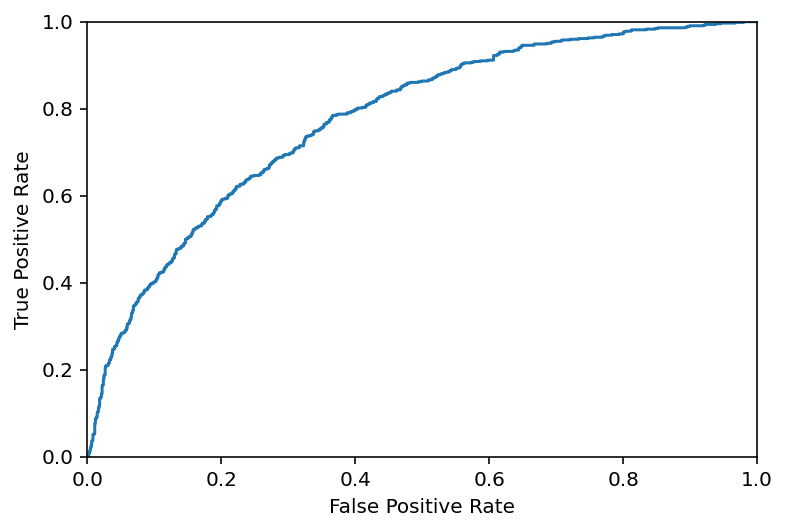

In [ ]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 

In [ ]:
auc_score=roc_auc_score(k_fold_y[test],y_val_cat_prob)

In [ ]:
auc_score

0.7755746576168286

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred=[1 if e >=0.5 else 0 for e in y_val_cat_prob]

In [ ]:
confusion_matrix(k_fold_y[test], y_pred)

array([[810, 283],
       [226, 419]])

In [ ]:
from sklearn.metrics import f1_score
f1_score(k_fold_y[test], y_pred, average='binary')

0.6221232368225685